<a href="https://colab.research.google.com/github/luc-perso/covid-19-xRay/blob/main/code_by_stefan/first_cnn_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#drive unzip Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#new_data
!unzip -q '/content/drive/MyDrive/datas/datanew.zip' -d '/content/'

In [ ]:
#equalized data
!unzip -q '/content/drive/MyDrive/datas/data_equalize.zip' -d '/content/'

In [ ]:
# COVID-19_Radiography_Dataset
!unzip -q '/content/drive/MyDrive/datas/archive.zip' -d '/content/'

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import json
import random
import itertools 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam

#Directorys 

In [ ]:
###COVID-19_Radiography_Dataset
cov_dir = r"/content/COVID-19_Radiography_Dataset/COVID"
norm_dir = r"/content/COVID-19_Radiography_Dataset/Normal"
opa_dir = r"/content/COVID-19_Radiography_Dataset/Lung_Opacity"
vir_dir = r"/content/COVID-19_Radiography_Dataset/Viral Pneumonia"
img = ["images"]
mas = ["masks"]

In [ ]:
#Datasets

db_path1 = '/content/data'
db_path2 = r'/content/COVID-19_Radiography_Dataset'
db_path3 = r'/content/data_equalize'
db_path4 = '/content/data prepro'
output_path = '../output'
if not os.path.exists(output_path):
  os.makedirs(output_path, exist_ok=True)

#############data names 

lung_name = 'lung'
infection_name = 'infection'

train_name = 'train'
test_name = 'test'
valid_name = 'valid'

no_covid_name = 'no_covid'
covid_name = 'covid19'
normal_name = 'normal'

images_name = 'images'
masks_name = 'masks'

lung_mask_name = lung_name + '_' + masks_name
infection_mask_name = infection_name + '_' + masks_name

#############data directory names 

lung_dirname = 'Lung Segmentation Data'
infection_dirname = 'Infection Segmentation Data'

train_dirname = 'Train'
test_dirname = 'Test'
valid_dirname = 'Val'

no_covid_dirname = 'Non-COVID'
covid_dirname = 'COVID-19'
normal_dirname = 'Normal'

images_dirname = 'images'
lung_masks_dirname = 'lung masks'
infection_masks_dirname = 'infection masks'


In [ ]:
############ path
db_names = pd.DataFrame(data={
  'db_name': [lung_name, infection_name],
  'db_dirname': [lung_dirname, infection_dirname]
  })
ds_names = pd.DataFrame(data={
  'ds_name': [train_name, test_name, valid_name],
  'ds_dirname': [train_dirname, test_dirname, valid_dirname]
  })
desease_names = pd.DataFrame(data={
  'desease_name': [no_covid_name, covid_name, normal_name],
  'desease_dirname': [no_covid_dirname, covid_dirname, normal_dirname]
  })
data_type_names = pd.DataFrame(data={
  'data_type_name': [images_name, lung_mask_name, infection_mask_name],
  'data_type_dirname': [images_dirname, lung_masks_dirname, infection_masks_dirname]
  })
print(db_names)
print(ds_names)
print(desease_names)
print(data_type_names)

db_names['keys'] = 1
ds_names['keys'] = 1
desease_names['keys'] = 1
data_type_names['keys'] = 1

#db_names
data_paths = pd.merge(db_names, ds_names, on='keys')
data_paths = pd.merge(data_paths, desease_names, on='keys')
data_paths = pd.merge(data_paths, data_type_names, on='keys')
data_paths = data_paths.drop(columns=['keys'])
#data_paths
data_paths = data_paths.set_index(['db_name', 'ds_name', 'desease_name', 'data_type_name'])
data_paths['path'] = data_paths.apply(lambda x: os.path.join(*(x.to_list())), axis=1)
data_paths = data_paths.iloc[:, -1:]

#data_paths
idx = pd.IndexSlice
index = data_paths.loc[idx[[lung_name],:,:,infection_mask_name]].index
print(index)
data_paths = data_paths.drop(index)

     db_name                   db_dirname
0       lung       Lung Segmentation Data
1  infection  Infection Segmentation Data
  ds_name ds_dirname
0   train      Train
1    test       Test
2   valid        Val
  desease_name desease_dirname
0     no_covid       Non-COVID
1      covid19        COVID-19
2       normal          Normal
    data_type_name data_type_dirname
0           images            images
1       lung_masks        lung masks
2  infection_masks   infection masks
MultiIndex([('lung', 'train', 'no_covid', 'infection_masks'),
            ('lung', 'train',  'covid19', 'infection_masks'),
            ('lung', 'train',   'normal', 'infection_masks'),
            ('lung',  'test', 'no_covid', 'infection_masks'),
            ('lung',  'test',  'covid19', 'infection_masks'),
            ('lung',  'test',   'normal', 'infection_masks'),
            ('lung', 'valid', 'no_covid', 'infection_masks'),
            ('lung', 'valid',  'covid19', 'infection_masks'),
            ('lung', '

In [ ]:
#####example 
path = data_paths['path'].loc[idx[[lung_name], valid_name, covid_name, images_name]][0]
print(path)
full_file_path = os.path.join(db_path1, path)
file_names = os.listdir(full_file_path)
file_names
print(file_names[0])
'''
n = np.random.randint(0, len(file_names))
print(n)
file_name = file_names[n]
#file_name = 'covid_1256.png'
#file_name = 'sub-S09683_ses-E25533_run-1_bp-chest_vp-ap_cr.png'
'''

Lung Segmentation Data/Val/COVID-19/images
sub-S11885_ses-E22941_run-1_bp-chest_vp-pa_dx.png


"\nn = np.random.randint(0, len(file_names))\nprint(n)\nfile_name = file_names[n]\n#file_name = 'covid_1256.png'\n#file_name = 'sub-S09683_ses-E25533_run-1_bp-chest_vp-ap_cr.png'\n"

# functions

In [ ]:
def path_creator(db_path1, lu_inf,tr_te_val, desease, img):
  path = data_paths['path'].loc[idx[[lu_inf], tr_te_val, desease, img]][0]
  full_file_path = os.path.join(db_path1, path)
  return full_file_path

In [ ]:
def img_path_n_list(path,class_num):
  img_path_list =[]
  img_list=[]  
  
  for img in os.listdir(path):
    try:
      file_path = os.path.join(path, img)
      img_path_list.append(file_path)
  
      # I import the images in gray scale
      img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
      #img_array = img_array/255
      img_array = cv2.resize(img_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    except:
      continue
    img_list.append([img_array,class_num])
  return img_path_list, img_list

In [ ]:
###### data import#########
# method for data import to a list and df
#import in grayscale and dsize 256*256 
def data_n_frame(catdir,sub, column_name):
    data_name =[]
    for x in sub:
        path = os.path.join(catdir, x)

        for img in os.listdir(path):
            # I import the images in gray scale
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
            data_name.append([img_array])
    dataframe = pd.DataFrame(data_name)
    dataframe = dataframe.rename(columns={0: column_name})

    return data_name, dataframe

In [ ]:
###### Classes Assignment #####
##for example, df_class = "covid"
def df_class( df_name,df_class):
    df_name["class"]= f"{df_class}"
    return df_name

# Data Creation

## equalized Lung infection data 

In [ ]:
p1=path_creator(db_path3, lung_name,train_name, covid_name, images_name)
p2=path_creator(db_path3, lung_name,train_name, no_covid_name, images_name)
p3=path_creator(db_path3, lung_name,train_name, normal_name, images_name)

pathlist1, list1 = img_path_n_list(p1,0)
pathlist2, list2 = img_path_n_list(p2,1)
pathlist3, list3 = img_path_n_list(p3,2)

lista=list1+list2+list3
random.shuffle(lista)

In [ ]:
X4 = []
y4 = []
imsize= 64
for features, label in lista :
    features = cv2.resize(features, (imsize,imsize))
    X4.append(features)
    y4.append(label)

X4=np.array(X4).reshape(-1, imsize, imsize, 1)
print(type(X4))
X4=X4/255


from keras.utils import to_categorical
y4= to_categorical(y4)
print(type(y4))
print(X4.shape, y4.shape)
X_train4 = X4
y_train4 = y4

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(21715, 64, 64, 1) (21715, 3)


In [ ]:
p1=path_creator(db_path3, lung_name,test_name, covid_name, images_name)
p2=path_creator(db_path3, lung_name,test_name, no_covid_name, images_name)
p3=path_creator(db_path3, lung_name,test_name, normal_name, images_name)

pathlist1, list1 = img_path_n_list(p1,0)
pathlist2, list2 = img_path_n_list(p2,1)
pathlist3, list3 = img_path_n_list(p3,2)

listb=list1+list2+list3
random.shuffle(listb)

In [ ]:
Xte4 = []
yte4 = []
imsize= 64
for features, label in listb :
    features = cv2.resize(features, (imsize,imsize))
    Xte4.append(features)
    yte4.append(label)

Xte4=np.array(Xte4).reshape(-1, imsize, imsize, 1)
print(type(Xte4))
Xte4=Xte4/255


from keras.utils import to_categorical
yte4= to_categorical(yte4)
print(type(yte4))
print(Xte4.shape, yte4.shape)
X_test4 = Xte4
y_test4 = yte4

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(6787, 64, 64, 1) (6787, 3)


In [ ]:
p1=path_creator(db_path3, lung_name,valid_name, covid_name, images_name)
p2=path_creator(db_path3, lung_name,valid_name, no_covid_name, images_name)
p3=path_creator(db_path3, lung_name,valid_name, normal_name, images_name)

pathlist1, list1 = img_path_n_list(p1,0)
pathlist2, list2 = img_path_n_list(p2,1)
pathlist3, list3 = img_path_n_list(p3,2)

listc=list1+list2+list3
random.shuffle(listc)

In [ ]:
Xva4 = []
yva4 = []
imsize= 64
for features, label in listc :
    features = cv2.resize(features, (imsize,imsize))
    Xva4.append(features)
    yva4.append(label)

Xva4=np.array(Xva4).reshape(-1, imsize, imsize, 1)
print(type(Xva4))
Xva4=Xva4/255


from keras.utils import to_categorical
yva4= to_categorical(yva4)
print(type(yva4))
print(Xva4.shape, yva4.shape)
X_val4 = Xva4
y_val4 = yva4

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(5416, 64, 64, 1) (5416, 3)


In [ ]:
x_train4 = tf.convert_to_tensor(X_train4)
y_train4 = tf.convert_to_tensor(y_train4)

x_test4 = tf.convert_to_tensor(X_test4)
y_test4 = tf.convert_to_tensor(y_test4)

x_val4 = tf.convert_to_tensor(X_val4)
y_val4 = tf.convert_to_tensor(y_val4)

## COVID-19_Radiography_Dataset unequalized

In [ ]:
#COVID-19_Radiography_Dataset
#xray
cov_xray_data, df_xray_cov =data_n_frame(cov_dir, img, "xray")
norm_xray_data, df_xray_norm =data_n_frame(norm_dir, img, "xray")
opa_xray_data, df_xray_opa =data_n_frame(opa_dir, img, "xray")
vir_xray_data, df_xray_vir =data_n_frame(vir_dir, img, "xray")

In [ ]:
df_non=pd.concat([df_xray_opa, df_xray_vir],ignore_index=True)
df_cov=df_xray_cov
df_norm = df_xray_norm
# assigning class
df_non =df_class(df_non, "non-covid")
df_cov =df_class(df_cov, "covid")
df_norm =df_class(df_norm, "normal")

In [ ]:
a_=df_cov
b_=df_non
c_=df_norm


In [ ]:
print(a_.shape, b_.shape,c_.shape)

(3616, 2) (7357, 2) (10192, 2)


In [ ]:
d="class"

In [ ]:
a1 = a_.iloc[int(len(a_) // 2):].copy()
b1 = b_.iloc[int(len(b_) // 2):].copy()
c1 = c_.iloc[int(len(c_) // 2):].copy()

In [ ]:
print(a1.shape, b1.shape,c1.shape)

(1808, 2) (3679, 2) (5096, 2)


In [ ]:
a2 = a_.iloc[:int(len(a_) // 2)].copy()
b2 = b_.iloc[:int(len(b_) // 2)].copy()
c2 = c_.iloc[:int(len(c_) // 2)].copy()

In [ ]:
print(a1.shape, b1.shape,c1.shape)

(1808, 2) (3679, 2) (5096, 2)


In [ ]:
df1=pd.concat([a1,b1,c1],ignore_index=True)
df2=pd.concat([a2,b2,c2],ignore_index=True)

In [ ]:
df1["class"]=df1["class"].replace({"covid":0, "non-covid":1,"normal":2})
df2["class"]=df2["class"].replace({"covid":0, "non-covid":1,"normal":2})

In [ ]:
imsize= 64
X1=[]
for i in df1[d]:
  i = cv2.resize(i, (imsize,imsize))
  X1.append(i)


X1 = np.array(X1).reshape(-1, imsize, imsize, 1)
X1=X1/255

In [ ]:
imsize= 64
X2=[]
for i in df2[d]:
  i = cv2.resize(i, (imsize,imsize))
  X2.append(i)


X2 = np.array(X2).reshape(-1, imsize, imsize, 1)
X2=X2/255

In [ ]:
y1=df1[d].values
from keras.utils import to_categorical
y1= to_categorical(y1)
y2=df2[d].values
from keras.utils import to_categorical
y2= to_categorical(y2)

In [ ]:
print(X1.shape,y1.shape)
print(X2.shape,y2.shape)

(10583, 64, 64, 1) (10583, 3)
(10582, 64, 64, 1) (10582, 3)


In [ ]:
X_train1, X_val1, y_train11, y_val11 = train_test_split(X1, y1, test_size=0.1, shuffle=True)
X_train1, X_test1, y_train11, y_test11 = train_test_split(X_train1, y_train11, test_size=0.2, shuffle=True)

In [ ]:
X_train2, X_val2, y_train22, y_val22 = train_test_split(X2, y2, test_size=0.1, shuffle=True)
X_train2, X_test2, y_train22, y_test22 = train_test_split(X_train2, y_train22, test_size=0.2, shuffle=True)

In [ ]:
x_train1 = tf.convert_to_tensor(X_train1)
y_train1 = tf.convert_to_tensor(y_train11)

x_test1 = tf.convert_to_tensor(X_test1)
y_test1 = tf.convert_to_tensor(y_test11)

x_val1 = tf.convert_to_tensor(X_val1)
y_val1 = tf.convert_to_tensor(y_val11)

In [ ]:
x_train2 = tf.convert_to_tensor(X_train2)
y_train2 = tf.convert_to_tensor(y_train22)

x_test2 = tf.convert_to_tensor(X_test2)
y_test2 = tf.convert_to_tensor(y_test22)

x_val2 = tf.convert_to_tensor(X_val2)
y_val2 = tf.convert_to_tensor(y_val22)

##infection segmentation data unequalized

In [ ]:
#these are just concat (train, test, val) of infection data images unequalized
#df_cov
apath="/content/drive/MyDrive/saves/All data in classes/df_cov_small.h5"
a = pd.read_hdf(apath, key='df')


#df_non
bpath="/content/drive/MyDrive/saves/All data in classes/df_non_small.h5"
b = pd.read_hdf(bpath, key='df')


#df_norm
cpath="/content/drive/MyDrive/saves/All data in classes/df_norm_small.h5"
c = pd.read_hdf(cpath, key='df')


#column of interest
d="xray"

In [ ]:
df=pd.concat([a,b,c],ignore_index=True)
print(df.info(),df.shape)
df["class"]=df["class"].replace({"covid":0, "non-covid":1,"normal":2})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825 entries, 0 to 5824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   xray    5825 non-null   object
 1   class   5825 non-null   object
dtypes: object(2)
memory usage: 91.1+ KB
None (5825, 2)


In [ ]:
imsize= 64
X=[]
for i in df[d]:
  i = cv2.resize(i, (imsize,imsize))
  X.append(i)

X = np.array(X).reshape(-1, imsize, imsize, 1)
X=X/255

print(type(X))
X.shape

<class 'numpy.ndarray'>


(5825, 64, 64, 1)

In [ ]:
y=df["class"].values
from keras.utils import to_categorical
y= to_categorical(y)
print(type(y))
y.shape

<class 'numpy.ndarray'>


(5825, 3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [ ]:
x_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

x_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

x_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

# first try with CNN-Model

##model

In [ ]:

# CNN-Model
model = tf.keras.Sequential()

# convolutional layers
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(imsize, imsize, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                      

##Learning on infection data

In [ ]:
initial_learning_rate = 0.002
steps= 5
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=40
training_history = model.fit(x_train, y_train,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_val, y_val),callbacks=[lr_callback, es_callback,stopper])    

Epoch 1/40
66/66 [==============================] - 26s 382ms/step - loss: 1.2268 - accuracy: 0.6370 - val_loss: 3.6809 - val_accuracy: 0.4597 - lr: 0.0020
Epoch 2/40
66/66 [==============================] - 27s 414ms/step - loss: 0.5971 - accuracy: 0.7603 - val_loss: 3.3634 - val_accuracy: 0.4597 - lr: 0.0020
Epoch 3/40
66/66 [==============================] - 25s 376ms/step - loss: 0.5236 - accuracy: 0.7908 - val_loss: 4.5868 - val_accuracy: 0.4597 - lr: 0.0020
Epoch 4/40
66/66 [==============================] - 25s 377ms/step - loss: 0.4784 - accuracy: 0.8078 - val_loss: 2.0525 - val_accuracy: 0.4597 - lr: 0.0020
Epoch 5/40
66/66 [==============================] - 25s 379ms/step - loss: 0.4140 - accuracy: 0.8307 - val_loss: 3.2222 - val_accuracy: 0.4580 - lr: 0.0020
Epoch 6/40
66/66 [==============================] - 26s 399ms/step - loss: 0.3576 - accuracy: 0.8545 - val_loss: 1.5494 - val_accuracy: 0.5472 - lr: 0.0016
Epoch 7/40
66/66 [==============================] - 25s 378ms/st

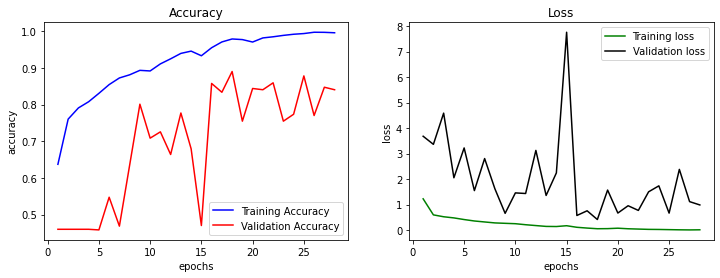

"\nplt.xlabel('epochs')\nplt.ylabel('accuracy')\n\nplt.plot(np.arange(1 , epochs+1, 1),\n         train_acc,\n         label = 'Training Accuracy',\n         color = 'blue')\nplt.plot(np.arange(1 , epochs+1, 1),\n         train_loss,\n         label = 'Training loss',\n         color = 'green')\nplt.plot(np.arange(1 , epochs+1, 1),\n         val_acc, \n         label = 'Validation Accuracy',\n         color = 'red')\nplt.plot(np.arange(1 , epochs+1, 1),\n         val_loss, \n         label = 'Validation loss',\n         color = 'black')\nplt.legend()\nplt.show()"

In [ ]:
if stopper.epoch == epochs:
  x= epochs +1
else:
  x=stopper.epoch+2

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
train_loss=training_history.history['loss']
val_loss=training_history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(1 , x, 1), train_acc, label = 'Training Accuracy', color = 'blue')
ax1.plot(np.arange(1 , x, 1), val_acc, label = 'Validation Accuracy', color = 'red')
ax1.legend()

ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.plot(np.arange(1 , x, 1), train_loss, label = 'Training loss', color = 'green')
ax2.plot(np.arange(1 , x, 1), val_loss, label = 'Validation loss', color = 'black')
ax2.legend()

plt.show()

## learning on infection and COVID-19_Radiography_Dataset combined

In [ ]:
x_train_g =tf.concat( [x_train,x_train1,x_train2], axis = 0)
y_train_g =tf.concat( [y_train,y_train1,y_train2], axis = 0)

x_test_g = tf.concat( [x_test,x_test1,x_test2], axis = 0)
y_test_g = tf.concat( [y_test,y_test1,y_test2], axis = 0)

x_val_g = tf.concat( [x_val,x_val1,x_val2], axis = 0)
y_val_g = tf.concat( [y_val,y_val1,y_val2], axis = 0)

In [ ]:
initial_learning_rate = 0.001
steps= 5
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=40
training_history = model.fit(x_train_g, y_train_g,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_val_g, y_val_g),callbacks=[lr_callback, es_callback,stopper])    

Epoch 1/40
304/304 [==============================] - 117s 384ms/step - loss: 0.1964 - accuracy: 0.9535 - val_loss: 0.1253 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 2/40
304/304 [==============================] - 115s 378ms/step - loss: 0.0852 - accuracy: 0.9666 - val_loss: 0.1630 - val_accuracy: 0.9526 - lr: 0.0010
Epoch 3/40
304/304 [==============================] - 114s 374ms/step - loss: 0.0698 - accuracy: 0.9736 - val_loss: 0.6680 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 4/40
304/304 [==============================] - 115s 377ms/step - loss: 0.0691 - accuracy: 0.9739 - val_loss: 0.3044 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 5/40
304/304 [==============================] - 114s 374ms/step - loss: 0.0577 - accuracy: 0.9773 - val_loss: 6.5156 - val_accuracy: 0.4117 - lr: 0.0010
Epoch 6/40
304/304 [==============================] - 115s 378ms/step - loss: 0.0616 - accuracy: 0.9761 - val_loss: 4.7052 - val_accuracy: 0.4587 - lr: 8.0000e-04
Epoch 7/40
304/304 [======================

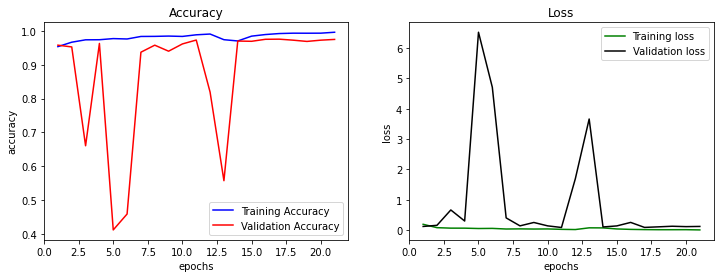

In [ ]:
if stopper.epoch == epochs:
  x= epochs +1
else:
  x=stopper.epoch+2

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
train_loss=training_history.history['loss']
val_loss=training_history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(1 , x, 1), train_acc, label = 'Training Accuracy', color = 'blue')
ax1.plot(np.arange(1 , x, 1), val_acc, label = 'Validation Accuracy', color = 'red')
ax1.legend()

ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.plot(np.arange(1 , x, 1), train_loss, label = 'Training loss', color = 'green')
ax2.plot(np.arange(1 , x, 1), val_loss, label = 'Validation loss', color = 'black')
ax2.legend()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/saves/CNN-Model/CNN_v4_g.h5')

In [ ]:
# Prediction de l'échantillon de test
test_pred = model.predict(x_test_g)

# Evaluation du modèle
score = model.evaluate(x_test_g, y_test_g)
score

152/152 [==============================] - 7s 49ms/step - loss: 0.1184 - accuracy: 0.9642


[0.11838845908641815, 0.9641901850700378]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = np.argmax(y_test_g, axis=1)

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1156
           1       0.94      0.97      0.95      1577
           2       0.98      0.97      0.97      2126

    accuracy                           0.96      4859
   macro avg       0.97      0.96      0.96      4859
weighted avg       0.96      0.96      0.96      4859



[[1082   54   20]
 [  11 1533   33]
 [   4   52 2070]]


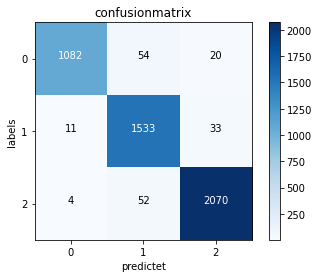

In [ ]:


cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

classes = range(0,3)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()


##learning on equalized Lung infection data

In [ ]:
initial_learning_rate = 0.001
steps= 5
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=40
training_history = model.fit(x_train4, y_train4,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_val4, y_val4),callbacks=[lr_callback, es_callback,stopper])    
         

Epoch 1/40
106/106 [==============================] - 49s 459ms/step - loss: 0.0977 - accuracy: 0.9662 - val_loss: 1.5994 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 2/40
106/106 [==============================] - 48s 451ms/step - loss: 0.0753 - accuracy: 0.9738 - val_loss: 0.8099 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 3/40
106/106 [==============================] - 48s 452ms/step - loss: 0.0655 - accuracy: 0.9757 - val_loss: 1.8913 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 4/40
106/106 [==============================] - 56s 534ms/step - loss: 0.0742 - accuracy: 0.9741 - val_loss: 0.9436 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 5/40
106/106 [==============================] - 47s 449ms/step - loss: 0.0554 - accuracy: 0.9805 - val_loss: 1.0181 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 6/40
106/106 [==============================] - 48s 453ms/step - loss: 0.0341 - accuracy: 0.9897 - val_loss: 1.0145 - val_accuracy: 0.8379 - lr: 8.0000e-04
Epoch 7/40
106/106 [============================

## learning false predicted

### creating data for false predicted images dataset

In [ ]:
pred= model.predict(x_train)
pred1=model.predict(x_train1)
pred2=model.predict(x_train2)
pred4=model.predict(x_train4)

679/679 [==============================] - 81s 119ms/step


In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)
predicted_class_indices1 = np.argmax(pred1,axis=1)
predicted_class_indices2 = np.argmax(pred2,axis=1)
predicted_class_indices4 = np.argmax(pred4,axis=1)



In [ ]:
pred = pd.DataFrame({'predictions':predicted_class_indices})
pred1 = pd.DataFrame({'predictions':predicted_class_indices1})
pred2 = pd.DataFrame({'predictions':predicted_class_indices2})
pred4 = pd.DataFrame({'predictions':predicted_class_indices4})

In [ ]:
x=x_train.numpy()
x1=x_train1.numpy()
x2=x_train2.numpy()
x4=x_train4.numpy()

In [ ]:
Z=[]
for i in x:
  Z.append([i])
  #print(i)
Z1=[]
for i in x1:
  Z1.append([i])
  #print(i)
Z2=[]
for i in x2:
  Z2.append([i])
  #print(i)
# Zg=[]
# for i in xg:
  # Zg.append([i])
  #print(i)
Z4=[]
for i in x4:
  Z4.append([i])
  #print(i)

In [ ]:
y= np.where(y_train == 1)[1]

y1=np.where(y_train1 == 1)[1]

y2=np.where(y_train2 == 1)[1]

#yg=np.where(y_train_g == 1)[1]

y4=np.where(y_train4 == 1)[1]

In [ ]:
df=pd.DataFrame({"Z":Z,"y":y})
df1=pd.DataFrame({"Z":Z1,"y":y1})
df2=pd.DataFrame({"Z":Z2,"y":y2})
df4=pd.DataFrame({"Z":Z4,"y":y4})

In [ ]:
tr=pd.concat([df,pred], axis=1)
tr1=pd.concat([df1,pred1], axis=1)
tr2=pd.concat([df2,pred2], axis=1)
tr4=pd.concat([df4,pred4], axis=1)

In [ ]:
trouble=pd.concat([tr,tr1,tr2,tr4], axis=0)
'''trg'''

'trg'

In [ ]:
df_filtered = trouble[trouble['y'] != trouble['predictions']]

In [ ]:
imsize= 64
X=[]
y=[]
for i,j in zip(df_filtered["Z"],df_filtered["y"]):
  X.append(i)
  y.append(j)
X = np.array(X).reshape(-1, imsize, imsize, 1)
print(type(X))
X.shape

<class 'numpy.ndarray'>


(10994, 64, 64, 1)

In [ ]:

from keras.utils import to_categorical
y= to_categorical(y)
print(type(y))
y.shape

<class 'numpy.ndarray'>


(10994, 3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [ ]:
x_troubtr = tf.convert_to_tensor(X_train)
y_troubtr = tf.convert_to_tensor(y_train1)

x_troubte = tf.convert_to_tensor(X_test)
y_troubte = tf.convert_to_tensor(y_test)

x_troubva = tf.convert_to_tensor(X_val)
y_troubva = tf.convert_to_tensor(y_val)

In [ ]:
print(x_troubtr.shape,y_troubtr.shape)

(7915, 64, 64, 1) (7915, 3)


### training on false predicted data

In [ ]:
initial_learning_rate = 0.001
steps= 3
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=50
training_history = model.fit(x_troubtr, y_troubtr,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_troubva, y_troubva),callbacks=[lr_callback, es_callback,stopper])

Epoch 1/50
124/124 [==============================] - 48s 376ms/step - loss: 0.3083 - accuracy: 0.8814 - val_loss: 0.2913 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 2/50
124/124 [==============================] - 44s 353ms/step - loss: 0.2857 - accuracy: 0.8892 - val_loss: 0.2878 - val_accuracy: 0.8909 - lr: 0.0010
Epoch 3/50
124/124 [==============================] - 44s 351ms/step - loss: 0.2809 - accuracy: 0.8925 - val_loss: 0.2772 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 4/50
124/124 [==============================] - 58s 468ms/step - loss: 0.2620 - accuracy: 0.9009 - val_loss: 0.2982 - val_accuracy: 0.8791 - lr: 8.0000e-04
Epoch 5/50
124/124 [==============================] - 55s 446ms/step - loss: 0.2563 - accuracy: 0.9068 - val_loss: 0.2909 - val_accuracy: 0.8864 - lr: 8.0000e-04
Epoch 6/50
124/124 [==============================] - 43s 350ms/step - loss: 0.2473 - accuracy: 0.9098 - val_loss: 0.2586 - val_accuracy: 0.8991 - lr: 8.0000e-04
Epoch 7/50
124/124 [====================

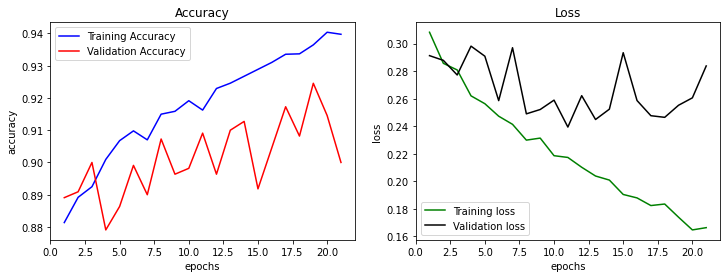

In [ ]:
if stopper.epoch == epochs:
  x= epochs +1
else:
  x=stopper.epoch+2

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
train_loss=training_history.history['loss']
val_loss=training_history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(1 , x, 1), train_acc, label = 'Training Accuracy', color = 'blue')
ax1.plot(np.arange(1 , x, 1), val_acc, label = 'Validation Accuracy', color = 'red')
ax1.legend()

ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.plot(np.arange(1 , x, 1), train_loss, label = 'Training loss', color = 'green')
ax2.plot(np.arange(1 , x, 1), val_loss, label = 'Validation loss', color = 'black')
ax2.legend()

plt.show()

In [ ]:
initial_learning_rate = 0.0001
steps= 3
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=50
training_history = model.fit(x_troubtr, y_troubtr,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_troubva, y_troubva),callbacks=[lr_callback, es_callback,stopper])


Epoch 1/50
124/124 [==============================] - 44s 350ms/step - loss: 0.1616 - accuracy: 0.9401 - val_loss: 0.2549 - val_accuracy: 0.9064 - lr: 1.0000e-04
Epoch 2/50
124/124 [==============================] - 43s 348ms/step - loss: 0.1583 - accuracy: 0.9437 - val_loss: 0.2534 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 3/50
124/124 [==============================] - 43s 349ms/step - loss: 0.1583 - accuracy: 0.9437 - val_loss: 0.2437 - val_accuracy: 0.9209 - lr: 1.0000e-04
Epoch 4/50
124/124 [==============================] - 46s 370ms/step - loss: 0.1492 - accuracy: 0.9468 - val_loss: 0.2539 - val_accuracy: 0.9191 - lr: 8.0000e-05
Epoch 5/50
124/124 [==============================] - 43s 350ms/step - loss: 0.1509 - accuracy: 0.9483 - val_loss: 0.2698 - val_accuracy: 0.9100 - lr: 8.0000e-05
Epoch 6/50
124/124 [==============================] - 44s 353ms/step - loss: 0.1461 - accuracy: 0.9473 - val_loss: 0.2503 - val_accuracy: 0.9200 - lr: 8.0000e-05
Epoch 7/50
124/124 [========

In [ ]:
test_pred = model.predict(x_troubte)

# Evaluation
score = model.evaluate(x_troubte, y_troubte)
score

62/62 [==============================] - 7s 110ms/step - loss: 0.2429 - accuracy: 0.9151


[0.24293018877506256, 0.9151086211204529]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = np.argmax(y_troubte, axis=1)

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67       145
           1       0.77      0.82      0.80       335
           2       0.97      0.96      0.97      1499

    accuracy                           0.92      1979
   macro avg       0.81      0.81      0.81      1979
weighted avg       0.92      0.92      0.92      1979



[[  94   36   15]
 [  28  275   32]
 [  12   45 1442]]


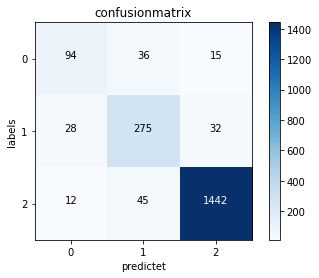

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()

###train again on equalized lung infection

In [ ]:
for layer in model.layers:
  print(layer)
  layer.trainable = False

In [ ]:
initial_learning_rate = 0.002
steps= 5
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=100
training_history = model.fit(x_train4, y_train4,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_val4, y_val4),callbacks=[lr_callback, es_callback,stopper])

Epoch 1/100
340/340 [==============================] - 93s 268ms/step - loss: 0.6420 - accuracy: 0.7565 - val_loss: 0.4705 - val_accuracy: 0.8270 - lr: 0.0020
Epoch 2/100
340/340 [==============================] - 93s 275ms/step - loss: 0.5243 - accuracy: 0.7978 - val_loss: 0.4603 - val_accuracy: 0.8309 - lr: 0.0020
Epoch 3/100
340/340 [==============================] - 89s 263ms/step - loss: 0.5079 - accuracy: 0.8058 - val_loss: 0.4523 - val_accuracy: 0.8368 - lr: 0.0020
Epoch 4/100
340/340 [==============================] - 90s 264ms/step - loss: 0.5073 - accuracy: 0.8058 - val_loss: 0.4526 - val_accuracy: 0.8353 - lr: 0.0020
Epoch 5/100
340/340 [==============================] - 91s 267ms/step - loss: 0.4980 - accuracy: 0.8087 - val_loss: 0.4618 - val_accuracy: 0.8342 - lr: 0.0020
Epoch 6/100
340/340 [==============================] - 89s 262ms/step - loss: 0.4888 - accuracy: 0.8149 - val_loss: 0.4542 - val_accuracy: 0.8351 - lr: 0.0016
Epoch 7/100
340/340 [=========================

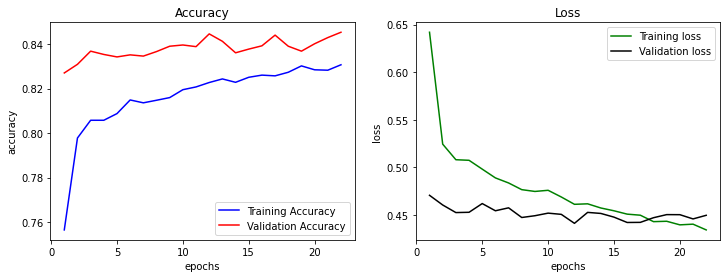

In [ ]:
if stopper.epoch == epochs:
  x= epochs +1
else:
  x=stopper.epoch+2

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
train_loss=training_history.history['loss']
val_loss=training_history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(1 , x, 1), train_acc, label = 'Training Accuracy', color = 'blue')
ax1.plot(np.arange(1 , x, 1), val_acc, label = 'Validation Accuracy', color = 'red')
ax1.legend()

ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.plot(np.arange(1 , x, 1), train_loss, label = 'Training loss', color = 'green')
ax2.plot(np.arange(1 , x, 1), val_loss, label = 'Validation loss', color = 'black')
ax2.legend()

plt.show()

In [ ]:
initial_learning_rate = 0.001
steps= 3
decay=0.8

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( initial_learning_rate= initial_learning_rate,decay_steps=steps,decay_rate=decay,staircase=True)
lr = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32, name="learning_rate")
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    lr.assign(lr_schedule(optimizer.iterations))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,mode="auto",baseline=None,restore_best_weights=True,)

class EpochStopper(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch

stopper = EpochStopper()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])


epochs=100
training_history = model.fit(x_train4, y_train4,         
                             epochs = epochs,               
                             batch_size = 64,          
                             validation_data=(x_val4, y_val4),callbacks=[lr_callback, es_callback,stopper])

Epoch 1/100
340/340 [==============================] - 136s 396ms/step - loss: 0.5135 - accuracy: 0.8114 - val_loss: 0.4675 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 2/100
340/340 [==============================] - 128s 377ms/step - loss: 0.4902 - accuracy: 0.8250 - val_loss: 0.4574 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 3/100
340/340 [==============================] - 127s 374ms/step - loss: 0.4791 - accuracy: 0.8303 - val_loss: 0.4704 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 4/100
340/340 [==============================] - 127s 374ms/step - loss: 0.4685 - accuracy: 0.8356 - val_loss: 0.4911 - val_accuracy: 0.8344 - lr: 8.0000e-04
Epoch 5/100
340/340 [==============================] - 125s 367ms/step - loss: 0.4603 - accuracy: 0.8364 - val_loss: 0.4667 - val_accuracy: 0.8480 - lr: 8.0000e-04
Epoch 6/100
340/340 [==============================] - 126s 370ms/step - loss: 0.4617 - accuracy: 0.8352 - val_loss: 0.4665 - val_accuracy: 0.8440 - lr: 8.0000e-04
Epoch 7/100
340/340 [=======

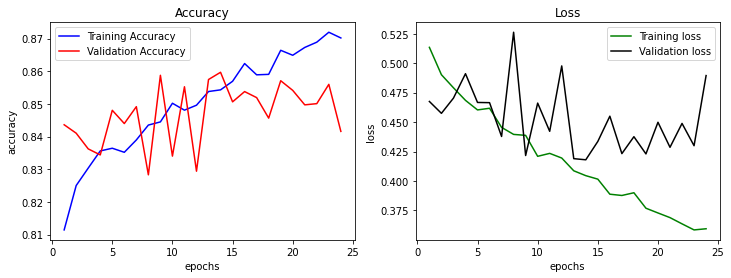

In [ ]:
if stopper.epoch == epochs:
  x= epochs +1
else:
  x=stopper.epoch+2

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
train_loss=training_history.history['loss']
val_loss=training_history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.plot(np.arange(1 , x, 1), train_acc, label = 'Training Accuracy', color = 'blue')
ax1.plot(np.arange(1 , x, 1), val_acc, label = 'Validation Accuracy', color = 'red')
ax1.legend()

ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.plot(np.arange(1 , x, 1), train_loss, label = 'Training loss', color = 'green')
ax2.plot(np.arange(1 , x, 1), val_loss, label = 'Validation loss', color = 'black')
ax2.legend()

plt.show()

In [ ]:
test_pred = model.predict(x_test4)

# Evaluation
score = model.evaluate(x_test4, y_test4)
score

213/213 [==============================] - 22s 105ms/step - loss: 0.3812 - accuracy: 0.8765


[0.3811889588832855, 0.8765286803245544]

In [ ]:
test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = np.argmax(y_test4, axis=1)

print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2394
           1       0.87      0.85      0.86      2253
           2       0.87      0.87      0.87      2140

    accuracy                           0.88      6787
   macro avg       0.88      0.88      0.88      6787
weighted avg       0.88      0.88      0.88      6787



[[2165  110  119]
 [ 163 1925  165]
 [  92  189 1859]]


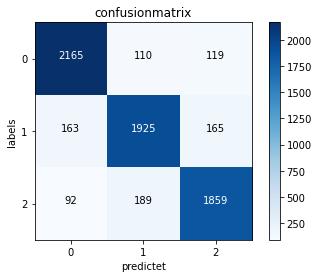

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)
classes = range(0,3)
plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusionmatrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('labels')
plt.xlabel('predictet')
plt.show()